## Введение в анализ данных, ИАД-1

## НИУ ВШЭ, 2018-19 учебный год

### Домашнее задание №2

Задание выполнил(а): Горбунов Иван


### Общая информация

__Дата выдачи:__ 25.02.2019

__Дедлайн:__ 23:59 5.03.2019

### О задании

В данном домашнем задании вы реализуете линейную регрессию своими руками и сравните её с версией в scikit-learn.

### Оценивание и штрафы

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

__Стирать условия нельзя!__

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Формат названия файла: homework_02_Фамилия_Имя.ipynb

## Часть 1. Обыкновенная линейная регрессия

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.base import BaseEstimator

### 1 (4 балла). 
На семинаре мы начали реализовывать класс линейной регрессии; теперь необходимо его закончить. 

In [11]:
class LinReg():
    def __init__(self, step_size=0.1, num_steps=20, eps=1e-6):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
    
    def __calc_grad(self, X_train, y_train):
        grad = 2 * np.dot(X_train.T, np.dot(X_train, self.w) - y_train) / X_train.shape[0]
        if(np.linalg.norm(self.step_size * grad)  < self.eps):     
            return np.zeros(self.w.shape)
        else:
            return  grad
    
    def fit(self, X_train, y_train):
        self.w = np.random.uniform(-1, 1, X_train.shape[1])
        for i in range(self.num_steps):
            grad = self.__calc_grad(X_train, y_train)
            if((grad==0).all()):
                return self
            else:
                self.w-=self.step_size*grad
            
        return self
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)

### 2 (3 балла). 
Проверим корректность работы класса на датасете Boston Housing. 
* Загрузите его из sklearn
* Проведите предобработку данных(нормализация вещественных признаков, one-hot encoding категориальных)
* Разделите на обучение и контроль в соотношении 80:20 с random_seed 42 (самый популярный в прошлом задании)
* Обучите собственную реализацию регрессии и сравните по метрикам MAE и RMSE с LinearRegression из sklearn.

In [12]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_target = pd.Series(boston_dataset.target)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [13]:
scaler = MinMaxScaler()
boston = scaler.fit_transform(boston)

In [14]:
lr1 = LinReg()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(boston, boston_target, shuffle=False, random_state=42)
lr = LinearRegression(n_jobs = -1,normalize=False)
lr.fit(X_train, y_train)
lr1.fit(X_train, y_train)
print('From box RMSE:', mean_squared_error(y_test, lr.predict(X_test))**0.5)
print('From my class RMSE:', mean_squared_error(y_test, lr1.predict(X_test))**0.5)
print('From box MAE:', mean_absolute_error(y_test, lr.predict(X_test)))
print('From my class MAE:', mean_absolute_error(y_test, lr1.predict(X_test)))

From box RMSE: 8.254979753549394
From my class RMSE: 8.241871437305003
From box MAE: 7.217075821808826
From my class MAE: 6.689978414972174


### 3 (3 балла). 
Линейная регрессия зачастую легко переобучается - модель необходимо штрафовать за величину весов; для этого применяют L1 и L2 регуляризацию: добавление нормы весов к функции потерь. В случае L2-регулязации функционал будет выглядеть как

$$ L = (Xw - y)^T(Xw - y) + \lambda||w||_2 $$.

Параметр $\lambda$ подбирается на отложенной выборке или по кросс-валидации.

* Реализуйте обучение линейной регрессии с L2-регуляризацией
* Найдите оптимальный с точки зрения метрики MAE коэффициент $\lambda$ (по кросс-валидации)
* Постройте график зависимости метрики на тестовой выборке от $\lambda$ (__подпишите оси__)
* Сравните результаты с Ridge регрессией из sklearn (аналогично пункту 2).

In [8]:
class LinRegL2(BaseEstimator):
    def __init__(self, alpha= 1, step_size=0.1, num_steps=20, eps=1e-6):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
        self.alpha = alpha
    def __calc_grad(self, X_train, y_train):
        grad = 2 * (self.alpha * self.w + np.dot(X_train.T, np.dot(X_train, self.w) - y_train) / X_train.shape[0])
        if(np.linalg.norm(self.step_size * grad)  < self.eps):     
            return np.zeros(self.w.shape)
        else:
            return  grad
    
    def fit(self, X_train, y_train):
        self.w = np.random.uniform(-1, 1, X_train.shape[1])
        for i in range(self.num_steps):
            grad = self.__calc_grad(X_train, y_train)
            if((grad == 0).all()):
                return self
            else:
                self.w-=self.step_size*grad
            
        return self
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)

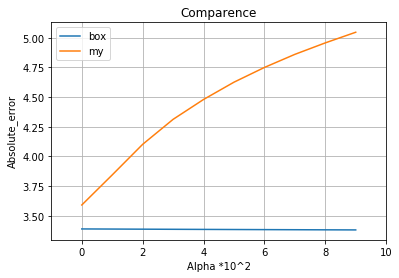

In [9]:
lr1_scores = []
lr2_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for l in range(10):
    lr2 = Ridge(alpha=l*0.01)
    lr1 = LinRegL2(alpha=l*0.01, num_steps=2000)
    lr2_scores.append(np.mean(cross_val_score(lr2, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
    lr1_scores.append(np.mean(cross_val_score(lr1, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
plt.plot(range(l+1), lr2_scores, label='box')
plt.plot(range(l+1), lr1_scores, label='my')
plt.title('Comparence')
plt.xlim((-1, l+1))
plt.legend()
plt.xlabel('Alpha *10^2')
plt.ylabel(r'Absolute_error')
plt.grid()
plt.show()

## В данном случае , лучше брать альфа равным нулю. Моя модель показывает результаты чуть хуже , так как не оптимизирован выбор начальных весов , шаг и скорость обучения

### 4 (Бонус, 4 балла). 
* Реализуйте обучение линейной регрессии с L1-регуляризацией (класс RegL1)
* Проведите сравнения аналогично пункту 3 (но с Lasso вместо Ridge).

In [66]:
class LinRegL1():
    def __init__(self, alpha= 1, step_size=0.1, num_steps=20, eps=1e-6):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
        self.alpha = alpha
    def __calc_grad(self, X_train, y_train):
        grad = 2 * (self.alpha * np.sign(self.w) + np.dot(X_train.T, np.dot(X_train, self.w) - y_train) / X_train.shape[0])
        if(np.dot(self.step_size * grad, self.step_size * grad)  < self.eps):     
            return np.zeros(self.w.shape)
        else:
            return  grad
    
    def fit(self, X_train, y_train):
        self.w = np.random.uniform(-1, 1, X_train.shape[1])
        for i in range(self.num_steps):
            grad = self.__calc_grad(X_train, y_train)
            if((grad == 0).all()):
                return self
            else:
                self.w-=self.step_size*grad
            
        return self
    
    def get_params(self, deep=False):
        return {
            'step_size': self.step_size, 'num_steps': self.num_steps, 'eps': self.eps, 'alpha': self.alpha
        }
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)

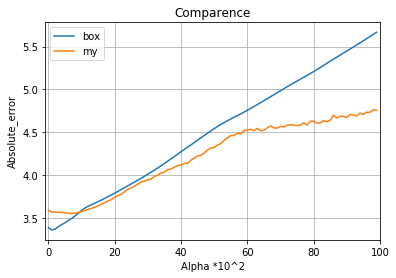

In [67]:
lr1_scores = []
lr2_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for l in range(100):
    lr2 = Lasso(alpha=l*0.01)
    lr1 = LinRegL1(alpha=l*0.01, num_steps=2000)
    lr2_scores.append(np.mean(cross_val_score(lr2, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
    lr1_scores.append(np.mean(cross_val_score(lr1, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
plt.plot(range(l+1), lr2_scores, label='box')
plt.plot(range(l+1), lr1_scores, label='my')
plt.title('Comparence')
plt.xlim((-1, l+1))
plt.legend()
plt.xlabel('Alpha *10^2')
plt.ylabel(r'Absolute_error')
plt.grid()
plt.show()

## Тут моя модель ведет себя гораздо лучше

### 5 (Бонус, 2 балла). 
Исследуйте для реализации регрессии с L2-регуляризацией зависимость качества на тестовой выборке (с графиками) от:
* Длины шага
* Количества шагов спуска
* Константы epsilon.

In [69]:
from collections import defaultdict
class LinRegL22(BaseEstimator):
    def __init__(self, alpha= 1, step_size=0.1, num_steps=20, eps=1e-6):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
        self.alpha = alpha
    def __calc_grad(self, X_train, y_train):
        grad = 2 * (self.alpha * self.w + np.dot(X_train.T, np.dot(X_train, self.w) - y_train) / X_train.shape[0])
        if(np.linalg.norm(self.step_size * grad)  < self.eps):     
            return np.zeros(self.w.shape)
        else:
            return  grad
    
    def fit(self, X_train, y_train):
        self.w = np.random.uniform(-1, 1, X_train.shape[1])
        for i in range(self.num_steps):
            grad = self.__calc_grad(X_train, y_train)
            if((grad == 0).all()):
                return self
            else:
                self.w-=self.step_size*grad
            
        return self
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)
    

In [70]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
l=LinRegL22()
par = {'step_size': np.arange(0.01,0.1,0.01), 'num_steps': np.arange(1000,2000,100), 'alpha':np.arange(0.01,0.1,0.01) }
clf = GridSearchCV(l, par, cv=kf, scoring=make_scorer(mean_absolute_error))
clf.fit(X_test, y_test)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LinRegL22(alpha=1, eps=1e-06, num_steps=20, step_size=0.1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'step_size': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]), 'num_steps': array([1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]), 'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [74]:
mean_absolute_error(y_test,clf.predict(X_test))

4.1106315634758746

In [75]:
clf.best_params_

{'alpha': 0.09, 'num_steps': 1000, 'step_size': 0.01}

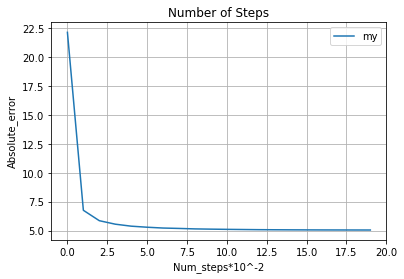

In [76]:
l_scores = []
for l in range(20):
    l4 = LinRegL22(alpha=0.09, num_steps=l*100, step_size=0.01)
    l_scores.append(np.mean(cross_val_score(l4, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
plt.plot(range(l+1), l_scores, label='my')
plt.title('Number of Steps')
plt.xlim((-1, l+1))
plt.legend()
plt.xlabel('Num_steps*10^-2')
plt.ylabel(r'Absolute_error')
plt.grid()
plt.show()

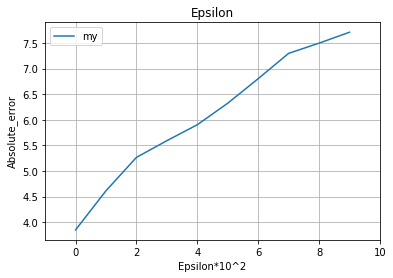

In [77]:
l_scores = []
for l in range(10):
    l4 = LinRegL22(alpha=0.01, num_steps=10000, step_size=0.01, eps=l*0.01)
    l_scores.append(np.mean(cross_val_score(l4, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
plt.plot(range(l+1), l_scores, label='my')
plt.title('Epsilon')
plt.xlim((-1, l+1))
plt.legend()
plt.xlabel('Epsilon*10^2')
plt.ylabel(r'Absolute_error')
plt.grid()
plt.show()

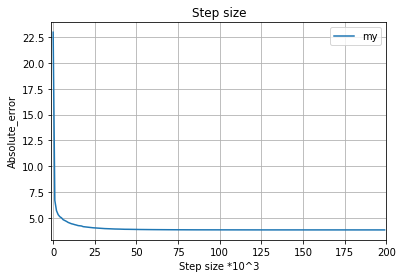

In [78]:
l_scores = []
for l in range(200):
    l4 = LinRegL22(alpha=0.01, num_steps=1000, step_size=0.001*l)
    l_scores.append(np.mean(cross_val_score(l4, boston, boston_target, cv=kf, scoring=make_scorer(mean_absolute_error))))
plt.plot(range(l+1), l_scores, label='my')
plt.title('Step size')
plt.xlim((-1, l+1))
plt.legend()
plt.xlabel('Step size *10^3')
plt.ylabel(r'Absolute_error')
plt.grid()
plt.show()

### 6 (Бонус, 0 баллов). 
Вставьте сюда любимую картинку, которая сможет поднять настроение ассистенту и семинаристу
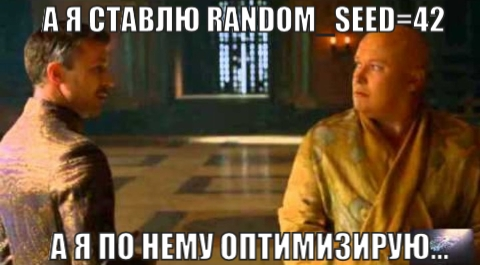